In [1]:
from jax import random
import jax.numpy as jnp
from jaxopt import Bisection
from numpyro import distributions as dists

import matplotlib.pyplot as plt
from ipywidgets import interactive

In [2]:
def zeta_rl(q_donor_accretor, β):
    """Approximate the adiabatic response of the Roche radius to mass lost, given a mass ratio and accretion efficiency."""
    part1 =  -2. * (1. - β * q_donor_accretor \
                    - (1. - β) * (q_donor_accretor + 1./2.) * (q_donor_accretor / (q_donor_accretor + 1.) )  )

    #part 2
    A = (q_donor_accretor**(1./3.)) / 3.
    B = 2./(q_donor_accretor**(1./3.))
    C = (  1.2 * q_donor_accretor**(1./3.) +  1./(1. + q_donor_accretor**(1./3)) ) \
        / (0.6 * q_donor_accretor**(2./3.) + jnp.log(1 + q_donor_accretor**(1./3.) ) )
    part2 =  A * (B - C)

    #part 3
    part3 =  1. + β*q_donor_accretor
    return part1 + part2 * part3

def critical_q_donor_to_accretor(ζeff, β):
    """Read off the limiting donor-to-accretor mass ratio given an effective limit on the adiabatic response."""
    func = lambda q_donor_accretor: zeta_rl(q_donor_accretor, β) - ζeff
    bisec = Bisection(
        optimality_fun=func,
        lower=0.01,
        upper=20,
    )
    return bisec.run().params

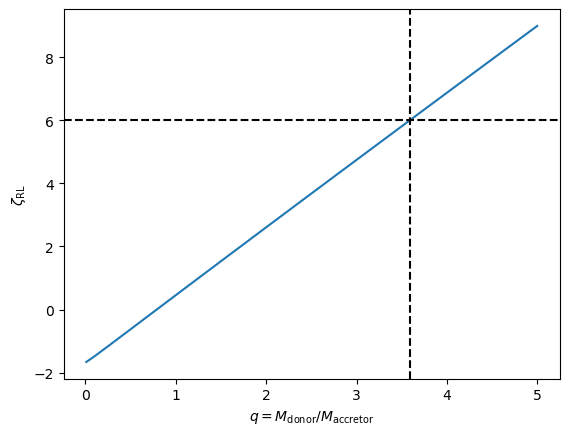

In [3]:
qs = jnp.linspace(.01, 5, 100)
β = 1.
ζeff = 6.
plt.plot(qs, zeta_rl(qs, β))

plt.axhline(ζeff, ls='--', color='k')
plt.axvline(critical_q_donor_to_accretor(ζeff, β), ls='--', color='k')
plt.xlabel(r'$q=M_\text{donor}/M_\text{accretor}$')
plt.ylabel(r'$\zeta_\text{RL}$');

In [4]:
def qzams_to_qbbh(q_zams, fcore, fsn_a, fsn_b, β):
    return ((1 - fsn_b) / (1 - fsn_a)) * (q_zams + β * (1 - fcore))

def qbbh_to_qzams(q_bbh, fcore, fsn_a, fsn_b, β):
    return q_ab * (1-fsn_a)/(1-fsn_b) - β * (1-fcore)

def q_premt2_to_qzams(q_premt2, fcore, fsn_a, fsn_b, β):
    return fcore * (1 - fsn_a) * q_premt2 - β * (1 - fcore)

In [5]:
n_binaries = 100_000

rng_key = random.PRNGKey(0)
q_zams = dists.Uniform(0.01, 1).sample(rng_key, (n_binaries,))

In [6]:
fcore = 0.34
fsn_a = 0.2
fsn_b = 0.2
β = 0.5

q_crit1_zams = 1/critical_q_donor_to_accretor(ζeff, β)
q_crit2_premt2 = critical_q_donor_to_accretor(ζeff, 0.)
q_crit2_zams = q_premt2_to_qzams(q_crit2_premt2, fcore, fsn_a, fsn_b, β)

survived_mt1 = q_zams > q_crit1_zams
survived_mt2 = q_zams < q_crit2_zams
survived = survived_mt1 & survived_mt2

q_bbh = qzams_to_qbbh(q_zams, fcore, fsn_a, fsn_b, β)

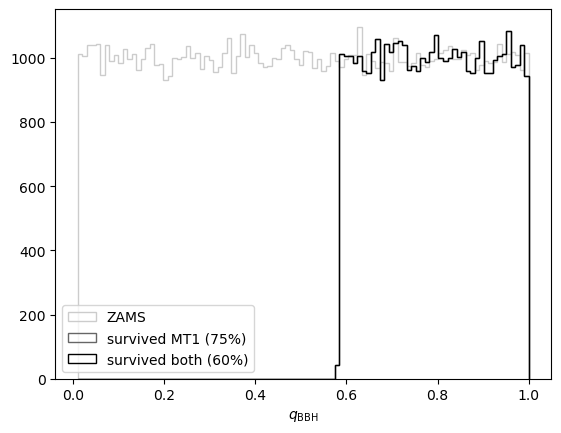

In [7]:
n_bins = 100
_, bins, _ = plt.hist(q_zams, bins=n_bins, color='.8', label='ZAMS', histtype='step')
plt.hist(q_bbh[survived_mt1], bins=bins, color='.4', label=f'survived MT1 ({100*jnp.mean(survived_mt1):.0f}%)', histtype='step')
plt.hist(q_bbh[survived], bins=bins, color='0', label=f'survived both ({100*jnp.mean(survived):.0f}%)', histtype='step')
plt.xlabel(r'$q_\text{BBH}$')
plt.legend();

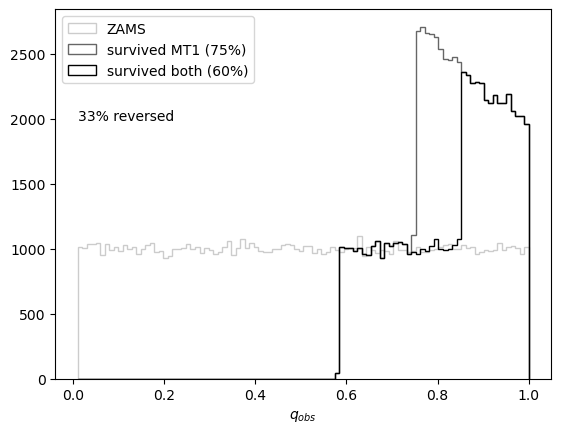

In [8]:
reversed = q_bbh > 1.
q_obs = jnp.where(reversed, 1/q_bbh, q_bbh)

_, bins, _ = plt.hist(q_zams, bins=n_bins, color='.8', label='ZAMS', histtype='step')
plt.hist(q_obs[survived_mt1], bins=bins, color='.4', label=f'survived MT1 ({100*jnp.mean(survived_mt1):.0f}%)', histtype='step')
plt.hist(q_obs[survived_mt1 & survived_mt2], bins=bins, color='0', label=f'survived both ({100*jnp.mean(survived):.0f}%)', histtype='step')
_, ymax = plt.ylim()
xmin, _ = plt.xlim()
plt.text(xmin+.05, ymax*.7, f'{100*jnp.mean(reversed):.0f}% reversed')
plt.xlabel(r'$q_{obs}$')
plt.legend();

In [9]:
def plot_qbbh(fcore, fsn_a, fsn_b, β, ζeff):
    q_crit1_zams = 1/critical_q_donor_to_accretor(ζeff, β)
    q_crit2_premt2 = critical_q_donor_to_accretor(ζeff, 0.)
    q_crit2_zams = q_premt2_to_qzams(q_crit2_premt2, fcore, fsn_a, fsn_b, β)

    q_crit1_bbh = qzams_to_qbbh(q_crit1_zams, fcore, fsn_a, fsn_b, β)
    q_crit2_bbh = qzams_to_qbbh(q_crit2_zams, fcore, fsn_a, fsn_b, β)

    survived_mt1 = q_zams > q_crit1_zams
    survived_mt2 = q_zams < q_crit2_zams
    survived = survived_mt1 & survived_mt2

    q_bbh = qzams_to_qbbh(q_zams, fcore, fsn_a, fsn_b, β)
    reversed = q_bbh > 1.

    plt.figure(figsize=(12, 4))
    _, bins, _ = plt.hist(q_zams, bins=n_bins, color='.8', label='ZAMS', histtype='step')
    plt.hist(q_bbh[survived_mt1], bins=bins, color='.4', label=rf'survived MT1 (${q_crit1_zams:.2f}<q_\text{{ZAMS}}$ | {100*jnp.mean(survived_mt1):.0f}%)', histtype='step')
    plt.hist(q_bbh[survived], bins=bins, color='0', label=rf'survived both (${q_crit1_zams:.2f}<q_\text{{ZAMS}}<{q_crit2_zams:.2f}$ | {100*jnp.mean(survived):.0f}%)', histtype='step')
    plt.axvline(q_crit1_bbh, ls='--', color='r')
    plt.axvline(q_crit2_bbh, ls='--', color='b')

    _, ymax = plt.ylim()
    xmin, _ = plt.xlim()
    plt.text(xmin+.05, ymax*.3, f'{100*jnp.mean(survived & reversed):.0f}% reversed')
    plt.xlabel(r'$q_\text{BBH}$')
    plt.legend(loc='lower left');

In [10]:
i_plot = interactive(
    plot_qbbh,
    fcore=(0, 1, .01),
    fsn_a=(0, 1, .01),
    fsn_b=(0, 1, .01),
    β=(0, 1, .01),
    ζeff=(1, 12, .01),
)
output = i_plot.children[-1]
output.layout.height = '380px'
i_plot

interactive(children=(FloatSlider(value=0.0, description='fcore', max=1.0, step=0.01), FloatSlider(value=0.0, …

In [11]:
def plot_qobs(fcore, fsn_a, fsn_b, β, ζeff):
    q_crit1_zams = 1/critical_q_donor_to_accretor(ζeff, β)
    q_crit2_premt2 = critical_q_donor_to_accretor(ζeff, 0.)
    q_crit2_zams = q_premt2_to_qzams(q_crit2_premt2, fcore, fsn_a, fsn_b, β)

    survived_mt1 = q_zams > q_crit1_zams
    survived_mt2 = q_zams < q_crit2_zams
    survived = survived_mt1 & survived_mt2

    q_bbh = qzams_to_qbbh(q_zams, fcore, fsn_a, fsn_b, β)
    reversed = q_bbh > 1.
    q_obs = jnp.where(reversed, 1/q_bbh, q_bbh)

    fig = plt.figure(figsize=(12, 4))
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, -1])
    _, bins, _ = ax1.hist(q_zams, bins=n_bins, color='.8', label='ZAMS', histtype='step')
    _, bins, _ = ax1.hist(q_zams[(q_crit1_zams < q_zams) & (q_zams < q_crit2_zams)], bins=n_bins, color='.8', label='ZAMS', histtype='stepfilled')
    ax1.hist(q_obs[survived_mt1], bins=bins, color='.4', label=rf'survived MT1 (${q_crit1_zams:.2f}<q_\text{{ZAMS}}$ | {100*jnp.mean(survived_mt1):.0f}%)', histtype='step')
    ax1.hist(q_obs[survived], bins=bins, color='0', label=rf'survived both (${q_crit1_zams:.2f}<q_\text{{ZAMS}}<{q_crit2_zams:.2f}$ | {100*jnp.mean(survived):.0f}%)', histtype='step')
    ax2.bar(
          ['MT1', '& MT2', '& Reversed'],
          [jnp.mean(survived_mt1), jnp.mean(survived), jnp.mean(survived & reversed)],
    )
    ax2.set_title('Survival Fractions')
    plt.xticks(rotation=45)

    ax1.set_xlabel(r'$q_\text{obs}$')
    ax1.legend(loc='lower left');

In [12]:
i_plot = interactive(
    plot_qobs,
    fcore=(0, 1, .01),
    fsn_a=(0, 1, .01),
    fsn_b=(0, 1, .01),
    β=(0, 1, .01),
    ζeff=(1, 12, .01),
)
output = i_plot.children[-1]
output.layout.height = '380px'
i_plot

interactive(children=(FloatSlider(value=0.0, description='fcore', max=1.0, step=0.01), FloatSlider(value=0.0, …